### Context
Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

### Attribute Information
Age: age of the patient [years] \
Sex: sex of the patient [M: Male, F: Female] \
ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic] \
RestingBP: resting blood pressure [mm Hg] \
Cholesterol: serum cholesterol [mm/dl] \
FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise] \
RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria] \
MaxHR: maximum heart rate achieved [Numeric value between 60 and 202] \
ExerciseAngina: exercise-induced angina [Y: Yes, N: No] \
Oldpeak: oldpeak = ST [Numeric value measured in depression] \
ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping] \
HeartDisease: output class [1: heart disease, 0: Normal] 

### Source
This dataset was created by combining different datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes. The five datasets used for its curation are:

Cleveland: 303 observations
Hungarian: 294 observations
Switzerland: 123 observations
Long Beach VA: 200 observations
Stalog (Heart) Data Set: 270 observations
Total: 1190 observations
Duplicated: 272 observations

Final dataset: 918 observations

Every dataset used can be found under the Index of heart disease datasets from UCI Machine Learning Repository on the following link: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

### Citation
fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

### Acknowledgements
#### Creators:

Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.
#### Donor:
David W. Aha (aha '@' ics.uci.edu) (714) 856-8779

### Import Libraries

In [1]:
import pandas as pd
import numpy as numpy
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

### Load Data Set

In [2]:
def load_data(path_to_salaries_csv):
    
    df = pd.read_csv(path_to_salaries_csv, sep = ",", header =0)
    
    return df

# Load the data using our function
heart_data = load_data('./heart.csv')

# Output the first 10 rows
print(heart_data.head())
print(heart_data["HeartDisease"].value_counts())
# Since there is a slight class imbalance, select random 400 entries for each class
heart_data = heart_data.groupby('HeartDisease').sample(n=400, random_state=0)
print(heart_data["HeartDisease"].value_counts())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR   
0   40   M           ATA        140          289          0     Normal    172  \
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
HeartDisease
1    508
0    410
Name: count, dtype: int64
HeartDisease
0    400
1    400
Name: count, dtype: int64


### Cleaning and Pre-processing Data

In [3]:
columns_to_binarize = ["Sex", "ChestPainType", "ST_Slope", "RestingECG"]

clean_heart_data = heart_data
for column in columns_to_binarize:

    # Convert column into binary fields where field name is "is_<attribute_value>"
    binary_columns = pd.get_dummies(clean_heart_data[column], dtype=float, prefix="is")

    # Drop the old column
    clean_heart_data = clean_heart_data.drop(column, axis=1)

    # Add the binarized columns to the data
    clean_heart_data = pd.concat([clean_heart_data, binary_columns], axis=1)

# We only have one feature to map to binary
clean_heart_data['ExerciseAngina'] = clean_heart_data['ExerciseAngina'].map({'N': 0, 'Y': 1})

# Print first 5 rows of cleaned data
print(clean_heart_data[:5])

     Age  RestingBP  Cholesterol  FastingBS  MaxHR  ExerciseAngina  Oldpeak   
700   42        148          244          0    178               0      0.8  \
121   52        125          272          0    139               0      0.0   
640   48        130          275          0    139               0      0.2   
844   52        118          186          0    190               0      0.0   
705   59        140          221          0    164               1      0.0   

     HeartDisease  is_F  is_M  is_ASY  is_ATA  is_NAP  is_TA  is_Down   
700             0   0.0   1.0     0.0     0.0     0.0    1.0      0.0  \
121             0   1.0   0.0     0.0     0.0     1.0    0.0      0.0   
640             0   1.0   0.0     0.0     0.0     1.0    0.0      0.0   
844             0   0.0   1.0     0.0     0.0     0.0    1.0      0.0   
705             0   0.0   1.0     0.0     1.0     0.0    0.0      0.0   

     is_Flat  is_Up  is_LVH  is_Normal  is_ST  
700      0.0    1.0     1.0        0.0

### Split and Standardize Data

In [4]:
X = clean_heart_data.loc[:, clean_heart_data.columns != 'HeartDisease']
y = clean_heart_data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Standardize the data
X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_train.mean()) / X_train.std()

# Print first 5 rows of standardized data
print(X_train_std[:5])             

          Age  RestingBP  Cholesterol  FastingBS     MaxHR  ExerciseAngina   
482  1.437954   0.452034     0.635000   1.811143 -0.513875       -0.768457  \
62  -0.857208   0.349416     0.191596  -0.551217  0.222910       -0.768457   
601  0.812000   0.349416     0.769949  -0.551217 -0.591431        1.299140   
544  0.812000   0.349416     0.904898   1.811143 -0.707766        1.299140   
433 -0.752883  -1.189861     0.307266  -0.551217 -0.513875        1.299140   

      Oldpeak      is_F      is_M    is_ASY    is_ATA    is_NAP     is_TA   
482  1.605298 -0.520321  0.520321 -1.022759 -0.525485 -0.538367  4.516030  \
62  -0.800003 -0.520321  0.520321  0.976118 -0.525485 -0.538367 -0.221064   
601  0.450753 -0.520321  0.520321 -1.022759 -0.525485  1.854374 -0.221064   
544 -0.800003  1.918686 -1.918686 -1.022759  1.899831 -0.538367 -0.221064   
433  1.124238 -0.520321  0.520321  0.976118 -0.525485 -0.538367 -0.221064   

      is_Down   is_Flat     is_Up    is_LVH  is_Normal     is_ST  
4

### Linear Regression

In [5]:
# Initialize and fit the logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train_std, y_train)

# Predict the target variable for the test set
y_pred = log_model.predict(X_test_std)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.86


### Confusion Matrix

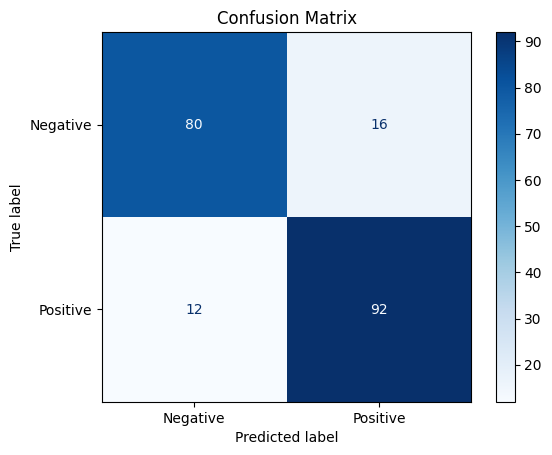

In [6]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [7]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

Accuracy: 0.86
Precision: 0.8518518518518519
Recall: 0.8846153846153846
F1-Score: 0.8679245283018868


### Naive Bayes

Naive Bayes:
Accuracy: 0.855
Precision: 0.8378378378378378
Recall: 0.8942307692307693
F1-score: 0.8651162790697674


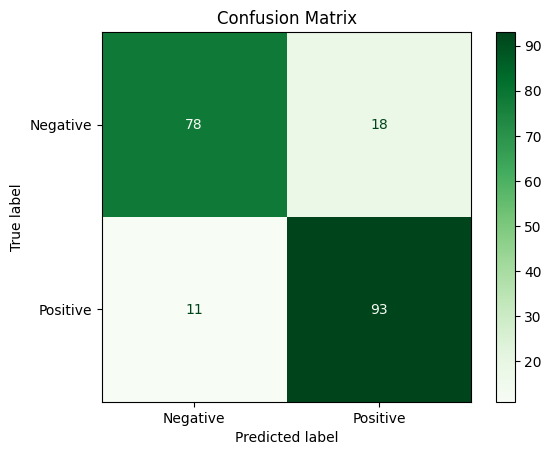

In [8]:
# Initialize and fit the Naive Bayes classifier
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_std, y_train)

# Predict the target variable using Naive Bayes
y_pred_nb = naive_bayes.predict(X_test_std)

# Calculate evaluation metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)
cm_nb = confusion_matrix(y_test, y_pred_nb)

print("Naive Bayes:")
print("Accuracy:", accuracy_nb)
print("Precision:", precision_nb)
print("Recall:", recall_nb)
print("F1-score:", f1_nb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Greens')
plt.title('Confusion Matrix')
plt.show()

### Decision Tree

Decision Tree:
Accuracy: 0.755
Precision: 0.7477477477477478
Recall: 0.7980769230769231
F1-score: 0.772093023255814


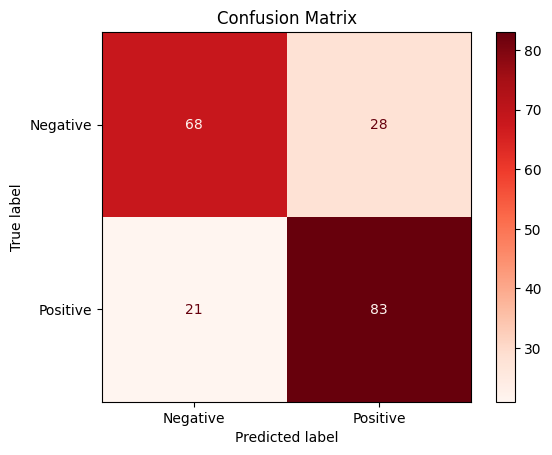

In [9]:
# Initialize and fit the Decision Tree classifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_std, y_train)

# Predict the target variable using Decision Tree
y_pred_dt = decision_tree.predict(X_test_std)

# Calculate evaluation metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

print("Decision Tree:")
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1-score:", f1_dt)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

### Feature Selection using PCA

In [10]:
pca = PCA()
pca.fit(X_train_std)

# Create a dictionary to store feature names and their variances
feature_variance = dict(zip(list(X_train_std.columns), pca.explained_variance_))

# Sort the feature_variance dictionary by variances in descending order
sorted_feature_variance = {k: v for k, v in sorted(feature_variance.items(), key=lambda feature: feature[1], reverse=True)}

# Print the feature rankings
rank = 1
for feature, variance in sorted_feature_variance.items():
    print(f"Rank {rank}: {feature} (Variance: {round(variance, 4)})")
    rank += 1

Rank 1: Age (Variance: 4.0073)
Rank 2: RestingBP (Variance: 2.0193)
Rank 3: Cholesterol (Variance: 1.7722)
Rank 4: FastingBS (Variance: 1.5558)
Rank 5: MaxHR (Variance: 1.3984)
Rank 6: ExerciseAngina (Variance: 1.2825)
Rank 7: Oldpeak (Variance: 1.127)
Rank 8: is_F (Variance: 1.0605)
Rank 9: is_M (Variance: 1.0159)
Rank 10: is_ASY (Variance: 0.8997)
Rank 11: is_ATA (Variance: 0.7963)
Rank 12: is_NAP (Variance: 0.6446)
Rank 13: is_TA (Variance: 0.5055)
Rank 14: is_Down (Variance: 0.4875)
Rank 15: is_Flat (Variance: 0.4274)
Rank 16: is_Up (Variance: 0.0)
Rank 17: is_LVH (Variance: 0.0)
Rank 18: is_Normal (Variance: 0.0)
Rank 19: is_ST (Variance: 0.0)


In [11]:
# Iterate through components to see which number of components gets the best results
for i in range(1,len(X_train_std.columns)):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train_std)

    # Transform the test set using the same PCA model
    X_test_pca = pca.transform(X_test_std)

    # Initialize and fit the logistic regression model
    log_model = LogisticRegression()
    log_model.fit(X_train_pca, y_train)

    # Predict the target variable for the test set
    y_pred = log_model.predict(X_test_pca)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print('Number of Components:', i)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-Score:', f1)
    print('')

Number of Components: 1
Accuracy: 0.86
Precision: 0.8454545454545455
Recall: 0.8942307692307693
F1-Score: 0.8691588785046728

Number of Components: 2
Accuracy: 0.885
Precision: 0.8785046728971962
Recall: 0.9038461538461539
F1-Score: 0.8909952606635071

Number of Components: 3
Accuracy: 0.87
Precision: 0.8611111111111112
Recall: 0.8942307692307693
F1-Score: 0.8773584905660378

Number of Components: 4
Accuracy: 0.87
Precision: 0.8611111111111112
Recall: 0.8942307692307693
F1-Score: 0.8773584905660378

Number of Components: 5
Accuracy: 0.87
Precision: 0.8679245283018868
Recall: 0.8846153846153846
F1-Score: 0.8761904761904762

Number of Components: 6
Accuracy: 0.87
Precision: 0.8679245283018868
Recall: 0.8846153846153846
F1-Score: 0.8761904761904762

Number of Components: 7
Accuracy: 0.88
Precision: 0.8773584905660378
Recall: 0.8942307692307693
F1-Score: 0.8857142857142858

Number of Components: 8
Accuracy: 0.875
Precision: 0.8691588785046729
Recall: 0.8942307692307693
F1-Score: 0.88151658